In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_cleaning import *
import numpy as np
from sklearn.model_selection import KFold

### **Data flow**

In [3]:
df_raw, df_Xn_raw = load_data()

In [4]:
fill_methods = ['mean', 'median', 'most_frequent']
std_methods = ['standard', 'minmax', 'maxabs', 'robust']

In [5]:
X, y = transform_data(df_raw, fill_methods[0], std_methods[0])

y      -4.218847e-17
x_ 1    6.344132e-17
x_ 2   -2.775558e-16
x_ 3   -4.119767e-16
x_ 4    8.712837e-16
            ...     
x_91    1.652425e-16
x_92   -9.036699e-16
x_93   -1.110223e-16
x_94    5.044984e-17
x_95   -3.291940e-17
Length: 96, dtype: float64
y       1.0
x_ 1    1.0
x_ 2    1.0
x_ 3    1.0
x_ 4    1.0
       ... 
x_91    1.0
x_92    1.0
x_93    1.0
x_94    1.0
x_95    1.0
Length: 96, dtype: float64


In [6]:
X

,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_ 1,C_ 2,C_ 3,C_ 4,C_ 5
0,0.143986,2.260189e-02,-2.850105e-01,-7.435489e-01,2.456093e+00,1.446173e-01,-6.147271e-01,-9.121041e-01,3.566176e-01,-9.206728e-17,...,-1.649033e+00,0.138263,9.793806e-02,8.378344e-01,1.704149e+00,2.0,1.0,1.0,3.0,4.0
1,0.516806,8.667054e-01,-2.673960e-01,8.712837e-16,-3.281814e-01,-6.263430e-01,-6.124337e-01,-1.137175e+00,-8.187895e-17,-7.773419e-02,...,-2.187538e-01,-0.912484,-1.838815e-01,-2.875376e-01,6.151883e-02,1.0,1.0,1.0,2.0,2.0
2,1.212469,-9.280076e-01,-5.290959e-02,-2.100282e-01,4.789575e-01,-1.364370e-16,-1.438641e-01,1.741032e-16,-3.645890e-01,-9.206728e-17,...,-7.706964e-01,0.651022,-8.439384e-01,-1.045923e-01,-1.052754e+00,0.0,1.0,4.0,3.0,0.0
3,-0.820630,-1.389646e+00,-1.197705e+00,-1.531863e+00,-1.787671e+00,-1.364370e-16,-1.104790e+00,-1.851163e+00,-9.946757e-01,-1.114715e+00,...,-3.171861e-01,-1.352818,-1.251456e-01,-1.296980e+00,-1.106595e+00,4.0,0.0,2.0,2.0,1.0
4,-1.658707,-1.950917e-01,-7.110901e-01,-2.541152e-01,-1.968123e-16,-1.564791e+00,-3.355622e-01,2.673742e-01,-1.106392e+00,-9.206728e-17,...,1.475805e-01,-0.726516,-1.233878e-01,5.044984e-17,7.463119e-02,1.0,0.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.369381,-2.775558e-16,8.412186e-01,-1.022040e-01,-3.236794e-01,8.246634e-01,4.054057e-01,2.648181e-01,-8.561281e-02,5.743276e-02,...,1.652425e-16,1.843120,3.940871e-01,1.071092e+00,2.198565e-01,1.0,1.0,0.0,2.0,1.0
96,1.185837,6.585023e-01,-4.119767e-16,-9.172382e-02,1.079191e+00,4.372737e-01,1.723159e-16,1.202554e+00,3.350057e-01,1.787323e+00,...,7.738873e-01,1.841760,1.254235e+00,8.664569e-01,-3.291940e-17,1.0,1.0,2.0,3.0,4.0
97,-2.502159,-1.724363e+00,-1.810019e+00,-6.697596e-01,-2.055407e+00,-9.044445e-01,-2.118585e+00,-1.763739e+00,-8.187895e-17,-2.706339e+00,...,-3.245595e+00,-1.812665,-1.110223e-16,-1.586817e+00,-7.744656e-01,0.0,0.0,2.0,0.0,4.0
98,0.202403,-1.341014e+00,-1.607346e-01,8.712837e-16,-1.968123e-16,-8.982464e-02,2.719395e-01,3.551797e-01,5.843045e-01,-9.206728e-17,...,-5.407144e-01,-0.306346,8.331026e-01,-9.655927e-01,-1.284772e+00,0.0,1.0,2.0,1.0,1.0


In [7]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_fit = lr.fit(df_final, y)
y_pred = lr_fit.predict(df_final)
mse(y, y_pred)

NameError: name 'df_final' is not defined

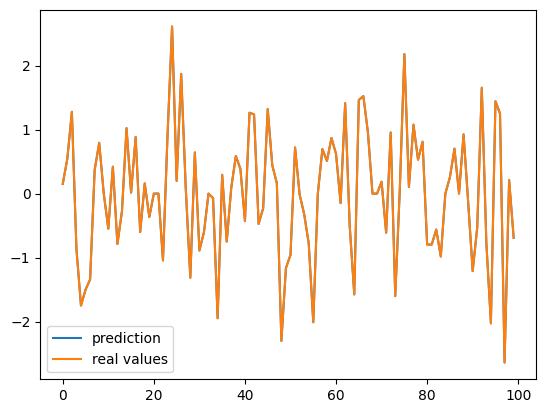

In [187]:
plt.plot(y_pred, label = 'prediction')
plt.plot(y, label = 'real values')
plt.legend()

In [3]:
import numpy as np

In [14]:
X_np = X.to_numpy()
y_np = y.to_numpy()

In [25]:
np.std(X_np[:,:95],axis = 0)

array([0.9486833 , 0.93273791, 0.92195445, 0.9539392 , 0.93273791,
       0.90553851, 0.91104336, 0.93273791, 0.88881944, 0.9       ,
       0.90553851, 0.90553851, 0.91104336, 0.89442719, 0.88881944,
       0.91651514, 0.93273791, 0.87749644, 0.93273791, 0.88317609,
       0.91651514, 0.89442719, 0.92736185, 0.89442719, 0.92195445,
       0.91651514, 0.88881944, 0.92736185, 0.90553851, 0.88881944,
       0.91104336, 0.92195445, 0.91651514, 0.9486833 , 0.90553851,
       0.9       , 0.90553851, 0.9       , 0.91651514, 0.90553851,
       0.88317609, 0.90553851, 0.91104336, 0.93808315, 0.9       ,
       0.9       , 0.84852814, 0.91651514, 0.92736185, 0.91104336,
       0.93808315, 0.88881944, 0.92195445, 0.93808315, 0.91651514,
       0.94339811, 0.93273791, 0.90553851, 0.94339811, 0.91651514,
       0.92195445, 0.90553851, 0.93273791, 0.89442719, 0.91651514,
       0.93273791, 0.88881944, 0.90553851, 0.91651514, 0.92736185,
       0.91104336, 0.87177979, 0.90553851, 0.91104336, 0.91104